# Data collection

### Importing libraries



In [6]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In order to analyze the performance of the `edf_hull` procedure on a large number of task sets, we need to generate a dataset of task sets. The dataset is generated by randomly sampling the parameters of the task sets, and then computing the minimal set of constraints for each task set. 

In [17]:
cmd = '../edf_hull --num=2 --period-min=4 --period-max=300000 --num-repeat=1000 -s --eps 1e-9 --relative-dl-var=0.3 --relative-dl-avg=1'

You are invited to the modify the above command as you wish, just keep in mind that the options **need to be specified using the equal sign notation** (e.g. `--num=2`). Alternative notations (e.g.`--num 2`), although valid in a terminal command, would interfere with the parsing employed later on in the notebook.

The following cell takes the command above and executes it.

In [18]:
import subprocess 

# Compile edf_hull
! cd ../ && make clean && make all && cd notebooks/

# Parse edf_hull command 
split_cmd = cmd.split(' ')
proc = subprocess.Popen(split_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Print output and potential errors  
o, e = proc.communicate()
print('Output:\n' + o.decode('ascii'))
print('Error: '  + e.decode('ascii'))
print('code: ' + str(proc.returncode))

rm -rf *.o *~ edf_hull edf_debug_qhull.txt 
cc -c -g -O0 -std=c89 -Wpedantic  edf_hull.c -o edf_hull.o
cc -c -g -O0 -std=c89 -Wpedantic  ts_lib.c -o ts_lib.o
cc -g -O0  main.c edf_hull.o ts_lib.o modules/qhull/lib/libqhullstatic_r.a -lm -o edf_hull
Output:
----------- Input arguments---------------------
-- n. repetitions:		1000		|
-- seed:			0		|
-- num tasks:			2		|
-- per min:			4.000000	|
-- per max:			300000.000000	|
-- phasing:			no		|
-- relative dl avg:		1.000000	|
-- relative dl var:		0.300000	|
-- eps:				0.000000	|
-- constraints info on csv:	no		|
------------------------------------------------
[edf_hull] Printing 1000 row(s) on file './../datasets/new/1k_t4-300000_d_avg1.0-var0.3.csv'

Error: 
code: 0


At the end of the execution, our dataset will be stored in a CSV file in the `../datasets/new/` folder. The name of the file will indicate the parameters used to generate the dataset.

### Selecting data subset

Given the first batch of data, we can now select a subset  that we deem interesting. 

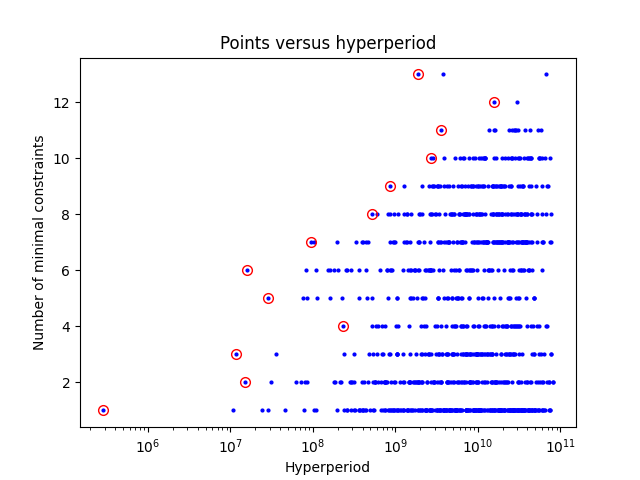

In [20]:
# Load data already available
df = pd.read_csv("../datasets/new/1k_t4-300000_d_avg1.0-var0.3.csv")


# Draw scatter plot where each point is a task set
fig, ax = plt.subplots()
ax.plot(df['H'], df['m'], '.', color='b', markersize=4)
ax.set_title('Points versus hyperperiod')
ax.set_xlabel('Hyperperiod')
ax.set_ylabel('Number of minimal constraints')

# Select rows in data where H is a minimum with equal m values
selected_list = df.loc[df.groupby(['m'])['H'].idxmin()]

# Circle selected points
ax.plot(selected_list['H'], selected_list['m'], 'o', mec='r', color='none', lw=1, markersize=7)

# Set x axis to log scale
ax.semilogx() 
plt.show()

An objective here is to establish an upper bound on the number of constraints that are needed to guarantee EDF schedulability given a particular set of task parameters. In this initial analysis, we will focus on the number $m$ of constraints compared to the hyperperiod ($H$) of the task set.

For each value of $m$, we will select the task sets that have the highest hyperperiod (points circled in red in the plot above).

In [21]:
## Read all the csv files' names in directory `../datasets/new/` 
from os import listdir
filenames = listdir("../datasets/new")

# Store all data found in said files into a single dataframe
all_data = pd.DataFrame()
for name in filenames:
  if name.endswith(".csv"):
    new_df = pd.read_csv("../datasets/new/" + name) 
    #deleting first row (header)
    all_data = pd.concat([all_data, new_df], ignore_index=True)

# Extract rows where H is a minimum with equal m values
selected_list = all_data.loc[all_data.groupby(['m'])['H'].idxmin()]

# Save extreme_list in csv
selected_list.to_csv('../datasets/selected.csv', index=False)

The resulting dataframe is converted to a csv format and saved as `selected.csv` in the `datasets` folder.

In [22]:
selected_list = pd.read_csv('../datasets/selected.csv')
selected_list

,Seed,T1,D1,Ratio1,T2,D2,Ratio2,H,m,Original_m,Percentage_m,Command
0,431,282240,352866.408003,1.250235,4032,5100.495996,1.265004,282240,1,160,0.018519,../edf_hull --num=2 --period-min=4 --period-ma...
1,617,30660,25384.633236,0.827940,104370,134752.591381,1.291105,15238020,2,649,0.006144,../edf_hull --num=2 --period-min=4 --period-ma...
2,132,85608,81825.369796,0.955815,1215,1017.815921,0.837709,11557080,3,9716,0.000515,../edf_hull --num=2 --period-min=4 --period-ma...
3,310,23497,20657.632459,0.879160,9753,8058.193935,0.826227,229166241,4,33254,0.000180,../edf_hull --num=2 --period-min=4 --period-ma...
4,536,21736,17777.138170,0.817866,115808,119648.244585,1.033160,28604576,5,1570,0.004453,../edf_hull --num=2 --period-min=4 --period-ma...
5,477,127648,115265.665292,0.902996,4000,4397.945513,1.099486,15956000,6,4144,0.001930,../edf_hull --num=2 --period-min=4 --period-ma...
6,17,171539,132706.863659,0.773625,559,698.913597,1.250293,95890301,7,172337,0.000052,../edf_hull --num=2 --period-min=4 --period-ma...
7,803,227447,159444.443784,0.701018,53153,53855.330941,1.013213,525630017,8,12204,0.000819,../edf_hull --num=2 --period-min=4 --period-ma...
8,750,79960,102212.093234,1.278290,86056,63297.479036,0.735538,860129720,9,20755,0.000530,../edf_hull --num=2 --period-min=4 --period-ma...
9,694,58679,41602.155956,0.708979,46008,49631.278184,1.078753,2699703432,10,104690,0.000115,../edf_hull --num=2 --period-min=4 --period-ma...


### Dataset specific to a singular task set 

The next step is to create a dataset specific to each singular task set and repeat the motion for each isolated case in the `selected` dataset.

In the following cell for each task set present in file `selected.csv`, a separate file csv is written: each row showcases a constraint's information. The newlly created files are saved in the `datasets` folder and named `n-<tasks-number>_m-<number-of-min-constraints>.csv`.

In [23]:
import subprocess

selected_list_csv = pd.read_csv("../datasets/selected.csv")
selected_list_csv

# Delete previous results
! rm ../datasets/additional_info/*.csv

# For each row extract command line and seed and 
for index, row in selected_list_csv.iterrows():
    seed = row['Seed']

    # Modify command line adding options:
    # · -e  to print additional data on file csv, 
    # · --rand-seed to reproduce specific task set
    whole_cmd = row['Command'] + ' -e --rand-seed=' + str(seed)
    split_cmd = whole_cmd.split(' ')

    # Run edf_hull 
    proc = subprocess.Popen(split_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Print output and potential errors
    o, e = proc.communicate()
    print('Output:\n' + o.decode('ascii')) # Note: the warning is not relevant for this particular execution
    print('Error: '  + e.decode('ascii'))
    print('code: ' + str(proc.returncode))
    

Error: 
code: 0
Error: 
code: 0
Error: 
code: 0
Error: 
code: 0
Error: 
code: 0
Error: 
code: 0
Error: 
code: 0
Error: 
code: 0
Error: 
code: 0
Error: 
code: 0
Error: 
code: 0
Error: 
code: 0
Error: 
code: 0
